# CTF-UCB on Greedy Casino PCH

This notebook demonstrates the training and evaluation of Counterfactual Upper Confidence Bound (CTF-UCB) algorithm on the Greedy Casino environment using Potential Causal History (PCH).

The Greedy Casino environment is a multi-armed bandit with confounding factors (Blinking B and Drunkenness D) that affect both the behavioral policy and the rewards. CTF-UCB leverages the natural behavioral policy's "intuition" as context to learn optimal counterfactual interventions.

## Environment Setup

In [1]:
import os
import sys
import time
from typing import List, Tuple, Any, Dict

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Set up paths and imports
sys.path.append('/Users/aurghyamaiti/Library/CloudStorage/OneDrive-Personal/Work/Research/CRL')

from causalgym.causal_gym.envs.greedy_casino import MABPCH
from causalrl.causal_rl.algo.ctf_do.ctfucb import CtfUCB, UCB

# Set matplotlib style  
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

/opt/homebrew/anaconda3/envs/causal-rl/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists
/opt/homebrew/anaconda3/envs/causal-rl/lib/python3.11/site-packages/gymnasium/envs/registration.py:636: UserWarning: WARN: Overriding environment causal_gym/RobotWalk-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/opt/homebrew/anaconda3/envs/causal-rl/lib/python3.11/site-packages/gymnasium/envs/registration.py:636: UserWarning: WARN: Overriding environment causal_gym/WindyGridWorld-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
/opt/homebrew/anaconda3/envs/causal-rl/lib/python3.11/site-packages/

## Training Configuration

In [2]:
# Training Configuration
CONFIG = {
    'episodes': 10000,
    'alpha': 2.0,  # UCB exploration parameter
    'seed': 42,
    'arms': [0, 1]  # Two arms in the greedy casino
}

# Create output directory if needed
OUTPUT_DIR = "/Users/aurghyamaiti/Library/CloudStorage/OneDrive-Personal/Work/Research/CRL/causalrl/examples/outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

print("Configuration loaded:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Configuration loaded:
  episodes: 10000
  alpha: 2.0
  seed: 42
  arms: [0, 1]


## Training Functions

In [3]:
def train_ctf_ucb(config):
    """Train CTF-UCB agent on Greedy Casino environment."""
    np.random.seed(config['seed'])
    
    # Initialize environment and agent
    env = MABPCH()
    agent = CtfUCB(arms=config['arms'], alpha=config['alpha'])
    
    # Tracking metrics
    episode_rewards = []
    episode_regrets = []
    natural_actions = []
    chosen_actions = []
    context_arm_rewards = defaultdict(list)  # Track rewards by (context, arm) pairs
    
    print(f"Starting CTF-UCB training for {config['episodes']} episodes...")
    print(f"Arms: {config['arms']}, Alpha: {config['alpha']}")
    
    start_time = time.time()
    
    for episode in range(config['episodes']):
        # Reset environment
        obs, info = env.reset(seed=config['seed'] + episode)
        
        # Get natural action (intuition from behavioral policy)
        obs, reward, terminated, truncated, info = env.see()
        natural_action = info['natural_action']
        natural_actions.append(natural_action)
        
        # Reset environment again to apply counterfactual intervention
        obs, info = env.reset(seed=config['seed'] + episode)
        
        # Select counterfactual action using CTF-UCB
        def ctf_policy(intuition):
            return agent.select_arm(intuition)
        
        # Apply counterfactual intervention
        obs, reward, terminated, truncated, info = env.ctf_do(ctf_policy)
        chosen_action = info['action']
        natural_action = info['natural_action']
        
        # Update agent with observed reward
        agent.update(natural_action, chosen_action, reward)
        
        # Track metrics
        episode_rewards.append(reward)
        chosen_actions.append(chosen_action)
        context_arm_rewards[(natural_action, chosen_action)].append(reward)

        regret = 0.45 - reward # Known optimal reward is 0.45
        episode_regrets.append(regret)
        
        # Progress logging
        if (episode + 1) % max(1, config['episodes'] // 10) == 0 or episode == config['episodes'] - 1:
            avg_reward = np.mean(episode_rewards[-100:]) if len(episode_rewards) >= 100 else np.mean(episode_rewards)
            cumulative_regret = np.sum(episode_regrets)
            print(f"Episode {episode+1:4d}/{config['episodes']} | "
                  f"Reward: {reward:.3f} | "
                  f"Avg Reward (last 100): {avg_reward:.3f} | "
                  f"Cumulative Regret: {cumulative_regret:.2f}")
    
    training_time = time.time() - start_time
    print(f"Training completed in {training_time:.2f} seconds")
    
    return {
        'agent': agent,
        'rewards': episode_rewards,
        'regrets': episode_regrets,
        'natural_actions': natural_actions,
        'chosen_actions': chosen_actions,
        'context_arm_rewards': context_arm_rewards,
        'training_time': training_time
    }

def train_baseline_ucb(config):
    """Train baseline UCB agent (ignoring context) for comparison."""
    np.random.seed(config['seed'])
    
    # Initialize environment and agent
    env = MABPCH()
    agent = UCB(arms=config['arms'], alpha=config['alpha'])
    
    # Tracking metrics
    episode_rewards = []
    episode_regrets = []
    chosen_actions = []
    
    print(f"Starting baseline UCB training for {config['episodes']} episodes...")
    
    start_time = time.time()
    
    for episode in range(config['episodes']):
        # Reset environment
        obs, info = env.reset(seed=config['seed'] + episode)
        
        # Select action using standard UCB (no context)
        chosen_action = agent.select_arm()
        
        # Apply intervention
        def do_policy():
            return chosen_action
            
        obs, reward, terminated, truncated, info = env.do(do_policy)
        
        # Update agent
        agent.update(chosen_action, reward)
        
        # Track metrics
        episode_rewards.append(reward)
        chosen_actions.append(chosen_action)
        
        # Calculate regret
        regret = 0.45 - reward # Known optimal reward is 0.45
        episode_regrets.append(regret)
    
    training_time = time.time() - start_time
    print(f"Baseline UCB training completed in {training_time:.2f} seconds")
    
    return {
        'agent': agent,
        'rewards': episode_rewards,
        'regrets': episode_regrets,
        'chosen_actions': chosen_actions,
        'training_time': training_time
    }

## Training Execution

In [4]:
# Train CTF-UCB agent
print("=" * 60)
print("Training CTF-UCB Agent")
print("=" * 60)
ctf_results = train_ctf_ucb(CONFIG)

print("\n" + "=" * 60)
print("Training Baseline UCB Agent")
print("=" * 60)
baseline_results = train_baseline_ucb(CONFIG)

print(f"\nTraining Summary:")
print(f"CTF-UCB Final Average Reward: {np.mean(ctf_results['rewards'][-100:]):.3f}")
print(f"Baseline UCB Final Average Reward: {np.mean(baseline_results['rewards'][-100:]):.3f}")
print(f"CTF-UCB Cumulative Regret: {np.sum(ctf_results['regrets']):.2f}")
print(f"Baseline UCB Cumulative Regret: {np.sum(baseline_results['regrets']):.2f}")

Training CTF-UCB Agent
Starting CTF-UCB training for 10000 episodes...
Arms: [0, 1], Alpha: 2.0
Episode 1000/10000 | Reward: 1.000 | Avg Reward (last 100): 0.460 | Cumulative Regret: 40.00
Episode 2000/10000 | Reward: 0.000 | Avg Reward (last 100): 0.430 | Cumulative Regret: 63.00
Episode 3000/10000 | Reward: 0.000 | Avg Reward (last 100): 0.380 | Cumulative Regret: 87.00
Episode 4000/10000 | Reward: 0.000 | Avg Reward (last 100): 0.400 | Cumulative Regret: 92.00
Episode 5000/10000 | Reward: 1.000 | Avg Reward (last 100): 0.460 | Cumulative Regret: 85.00
Episode 6000/10000 | Reward: 0.000 | Avg Reward (last 100): 0.420 | Cumulative Regret: 93.00
Episode 7000/10000 | Reward: 0.000 | Avg Reward (last 100): 0.370 | Cumulative Regret: 99.00
Episode 8000/10000 | Reward: 0.000 | Avg Reward (last 100): 0.460 | Cumulative Regret: 109.00
Episode 9000/10000 | Reward: 0.000 | Avg Reward (last 100): 0.360 | Cumulative Regret: 132.00
Episode 10000/10000 | Reward: 0.000 | Avg Reward (last 100): 0.54

## Visualization and Analysis

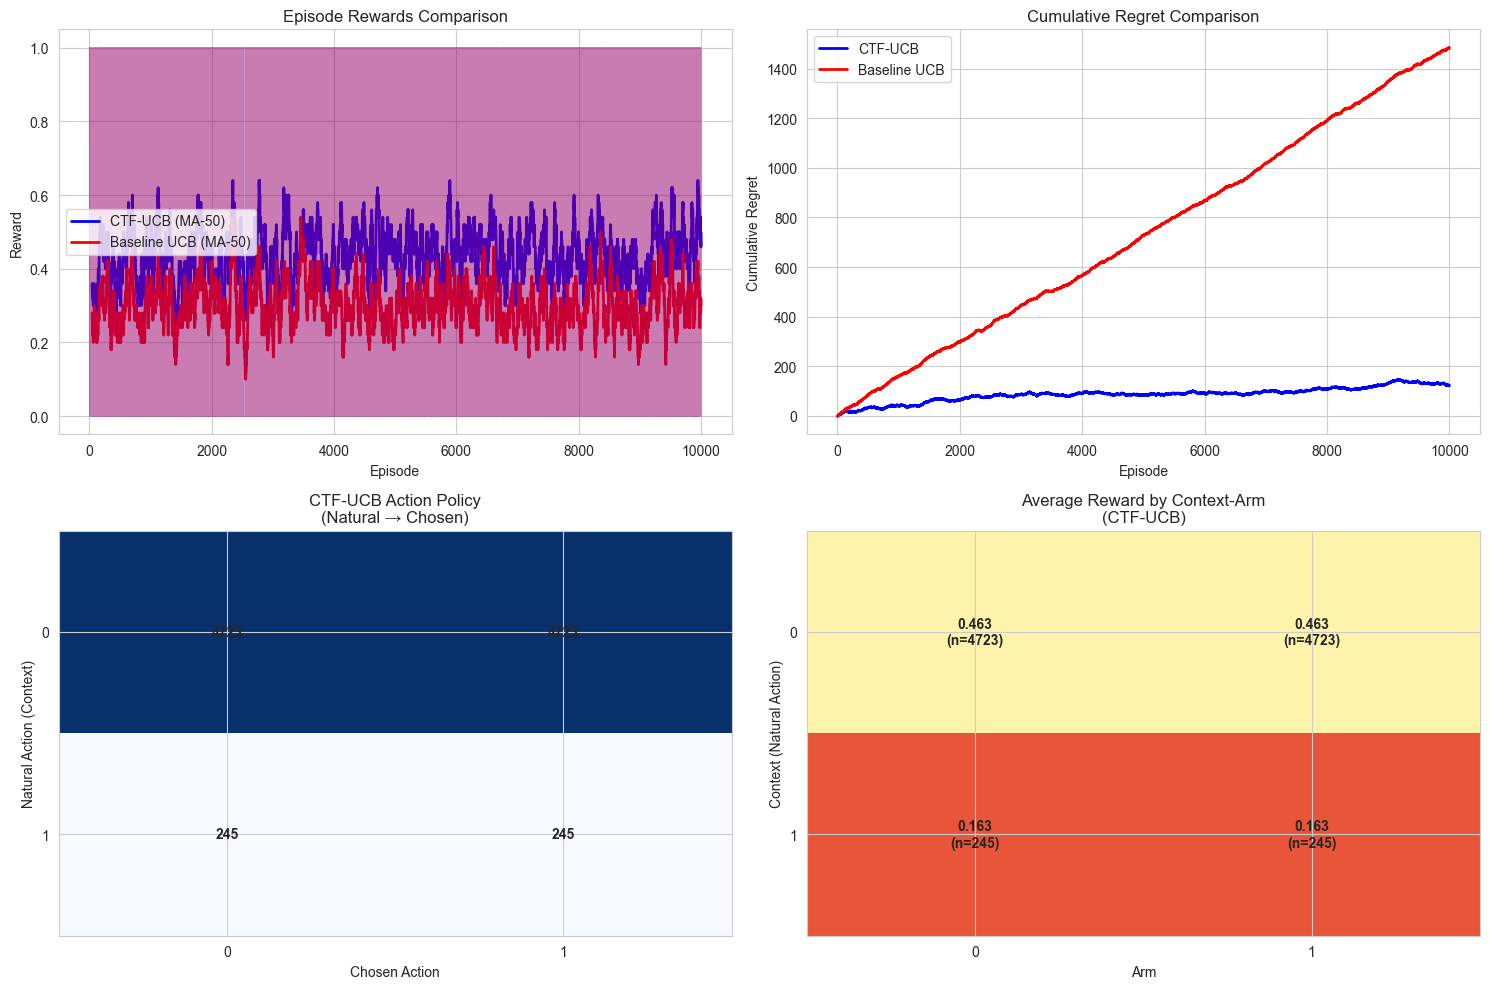

In [5]:
def plot_training_comparison(ctf_results, baseline_results, config):
    """Plot comparison between CTF-UCB and baseline UCB."""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    episodes = range(1, len(ctf_results['rewards']) + 1)
    
    # 1. Episode rewards comparison
    window = 50
    if len(ctf_results['rewards']) >= window:
        ctf_moving_avg = np.convolve(ctf_results['rewards'], np.ones(window)/window, mode='valid')
        baseline_moving_avg = np.convolve(baseline_results['rewards'], np.ones(window)/window, mode='valid')
        
        ax1.plot(range(window-1, len(episodes)), ctf_moving_avg, 'b-', label=f'CTF-UCB (MA-{window})', linewidth=2)
        ax1.plot(range(window-1, len(episodes)), baseline_moving_avg, 'r-', label=f'Baseline UCB (MA-{window})', linewidth=2)
    
    ax1.plot(episodes, ctf_results['rewards'], 'b-', alpha=0.3, linewidth=0.5)
    ax1.plot(episodes, baseline_results['rewards'], 'r-', alpha=0.3, linewidth=0.5)
    ax1.set_xlabel('Episode')
    ax1.set_ylabel('Reward')
    ax1.set_title('Episode Rewards Comparison')
    ax1.legend()
    ax1.grid(True)
    
    # 2. Cumulative regret comparison
    ctf_cumulative_regret = np.cumsum(ctf_results['regrets'])
    baseline_cumulative_regret = np.cumsum(baseline_results['regrets'])
    
    ax2.plot(episodes, ctf_cumulative_regret, 'b-', label='CTF-UCB', linewidth=2)
    ax2.plot(episodes, baseline_cumulative_regret, 'r-', label='Baseline UCB', linewidth=2)
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Cumulative Regret')
    ax2.set_title('Cumulative Regret Comparison')
    ax2.legend()
    ax2.grid(True)
    
    # 3. Action distribution for CTF-UCB
    natural_actions = ctf_results['natural_actions']
    chosen_actions = ctf_results['chosen_actions']
    
    # Create contingency table
    contingency = np.zeros((2, 2))
    for nat, chosen in zip(natural_actions, chosen_actions):
        contingency[nat, chosen] += 1
    
    im1 = ax3.imshow(contingency, cmap='Blues', aspect='auto')
    ax3.set_xticks([0, 1])
    ax3.set_yticks([0, 1])
    ax3.set_xlabel('Chosen Action')
    ax3.set_ylabel('Natural Action (Context)')
    ax3.set_title('CTF-UCB Action Policy\n(Natural → Chosen)')
    
    # Add text annotations
    for i in range(2):
        for j in range(2):
            ax3.text(j, i, f'{int(contingency[i, j])}', 
                    ha='center', va='center', fontweight='bold')
    
    # 4. Reward by context-action pairs
    contexts = [0, 1]
    arms = [0, 1]
    context_rewards = np.zeros((2, 2))
    context_counts = np.zeros((2, 2))
    
    for (context, arm), rewards in ctf_results['context_arm_rewards'].items():
        context_rewards[context, arm] = np.mean(rewards)
        context_counts[context, arm] = len(rewards)
    
    im2 = ax4.imshow(context_rewards, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)
    ax4.set_xticks([0, 1])
    ax4.set_yticks([0, 1])
    ax4.set_xlabel('Arm')
    ax4.set_ylabel('Context (Natural Action)')
    ax4.set_title('Average Reward by Context-Arm\n(CTF-UCB)')
    
    # Add text annotations with counts
    for i in range(2):
        for j in range(2):
            if context_counts[i, j] > 0:
                ax4.text(j, i, f'{context_rewards[i, j]:.3f}\n(n={int(context_counts[i, j])})', 
                        ha='center', va='center', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f'ctf_ucb_greedy_casino_comparison.png'), dpi=300, bbox_inches='tight')
    plt.show()

# Generate comparison plots
plot_training_comparison(ctf_results, baseline_results, CONFIG)

## Detailed Analysis

In [6]:
def analyze_ctf_performance(ctf_results, baseline_results, config):
    """Provide detailed analysis of CTF-UCB performance."""
    
    print("=" * 80)
    print("DETAILED PERFORMANCE ANALYSIS")
    print("=" * 80)
    
    # Overall performance metrics
    ctf_total_reward = sum(ctf_results['rewards'])
    baseline_total_reward = sum(baseline_results['rewards'])
    ctf_avg_reward = np.mean(ctf_results['rewards'])
    baseline_avg_reward = np.mean(baseline_results['rewards'])
    
    print(f"\n📊 OVERALL PERFORMANCE")
    print(f"{'Algorithm':<15} {'Total Reward':<12} {'Avg Reward':<12} {'Cumulative Regret':<18}")
    print(f"{'-'*60}")
    print(f"{'CTF-UCB':<15} {ctf_total_reward:<12.2f} {ctf_avg_reward:<12.4f} {sum(ctf_results['regrets']):<18.2f}")
    print(f"{'Baseline UCB':<15} {baseline_total_reward:<12.2f} {baseline_avg_reward:<12.4f} {sum(baseline_results['regrets']):<18.2f}")
    
    improvement = ((ctf_avg_reward - baseline_avg_reward) / baseline_avg_reward) * 100
    print(f"\n🎯 CTF-UCB Improvement: {improvement:+.2f}%")
    
    # Context-specific analysis
    print(f"\n🔍 CONTEXT-SPECIFIC ANALYSIS")
    print("CTF-UCB Context-Action Performance:")
    
    context_performance = {}
    for (context, arm), rewards in ctf_results['context_arm_rewards'].items():
        avg_reward = np.mean(rewards)
        count = len(rewards)
        context_performance[(context, arm)] = (avg_reward, count)
        print(f"  Context {context} → Arm {arm}: {avg_reward:.4f} (n={count})")
    
    # Action selection patterns
    print(f"\n🎮 ACTION SELECTION PATTERNS")
    natural_actions = ctf_results['natural_actions']
    chosen_actions = ctf_results['chosen_actions']
    
    # Count following vs. overriding natural actions
    follow_count = sum(1 for n, c in zip(natural_actions, chosen_actions) if n == c)
    override_count = len(natural_actions) - follow_count
    
    print(f"  Natural action followed: {follow_count}/{len(natural_actions)} ({100*follow_count/len(natural_actions):.1f}%)")
    print(f"  Natural action overridden: {override_count}/{len(natural_actions)} ({100*override_count/len(natural_actions):.1f}%)")
    
    # Analyze override success
    follow_rewards = [r for n, c, r in zip(natural_actions, chosen_actions, ctf_results['rewards']) if n == c]
    override_rewards = [r for n, c, r in zip(natural_actions, chosen_actions, ctf_results['rewards']) if n != c]
    
    if follow_rewards and override_rewards:
        print(f"  Average reward when following: {np.mean(follow_rewards):.4f}")
        print(f"  Average reward when overriding: {np.mean(override_rewards):.4f}")
    
    # Learning curve analysis
    print(f"\n📈 LEARNING CURVE ANALYSIS")
    early_episodes = config['episodes'] // 4
    late_episodes = config['episodes'] // 4
    
    ctf_early_reward = np.mean(ctf_results['rewards'][:early_episodes])
    ctf_late_reward = np.mean(ctf_results['rewards'][-late_episodes:])
    baseline_early_reward = np.mean(baseline_results['rewards'][:early_episodes])
    baseline_late_reward = np.mean(baseline_results['rewards'][-late_episodes:])
    
    print(f"  CTF-UCB: Early {ctf_early_reward:.4f} → Late {ctf_late_reward:.4f} (Δ={ctf_late_reward-ctf_early_reward:+.4f})")
    print(f"  Baseline: Early {baseline_early_reward:.4f} → Late {baseline_late_reward:.4f} (Δ={baseline_late_reward-baseline_early_reward:+.4f})")
    
    # Agent state inspection
    print(f"\n🤖 FINAL AGENT STATE")
    print("CTF-UCB learned values:")
    for (context, arm) in [(0, 0), (0, 1), (1, 0), (1, 1)]:
        key = (context, arm)
        value = ctf_results['agent'].values.get(key, 0.0)
        count = ctf_results['agent'].counts.get(key, 0)
        print(f"  Context {context}, Arm {arm}: Value={value:.4f}, Count={count}")
    
    print("\nBaseline UCB learned values:")
    for arm in [0, 1]:
        value = baseline_results['agent'].values[arm]
        count = baseline_results['agent'].counts[arm]
        print(f"  Arm {arm}: Value={value:.4f}, Count={count}")

# Run detailed analysis
analyze_ctf_performance(ctf_results, baseline_results, CONFIG)

DETAILED PERFORMANCE ANALYSIS

📊 OVERALL PERFORMANCE
Algorithm       Total Reward Avg Reward   Cumulative Regret 
------------------------------------------------------------
CTF-UCB         4377.00      0.4377       123.00            
Baseline UCB    3016.00      0.3016       1484.00           

🎯 CTF-UCB Improvement: +45.13%

🔍 CONTEXT-SPECIFIC ANALYSIS
CTF-UCB Context-Action Performance:
  Context True → Arm 0: 0.4628 (n=4723)
  Context True → Arm 1: 0.1633 (n=245)
  Context False → Arm 0: 0.1533 (n=261)
  Context False → Arm 1: 0.4425 (n=4771)

🎮 ACTION SELECTION PATTERNS
  Natural action followed: 506/10000 (5.1%)
  Natural action overridden: 9494/10000 (94.9%)
  Average reward when following: 0.1581
  Average reward when overriding: 0.4526

📈 LEARNING CURVE ANALYSIS
  CTF-UCB: Early 0.4188 → Late 0.4396 (Δ=+0.0208)
  Baseline: Early 0.3036 → Late 0.2984 (Δ=-0.0052)

🤖 FINAL AGENT STATE
CTF-UCB learned values:
  Context 0, Arm 0: Value=0.1533, Count=261
  Context 0, Arm 1: Value=0

## Confounding Analysis

In [7]:
def analyze_confounding_effects(config):
    """Analyze the effect of confounding in the Greedy Casino environment."""
    
    print("=" * 80)
    print("CONFOUNDING ANALYSIS")
    print("=" * 80)
    
    # Collect observational data to understand confounding
    np.random.seed(config['seed'])
    env = MABPCH()
    
    observational_data = []
    n_samples = 5000
    
    print(f"Collecting {n_samples} observational samples...")
    
    for i in range(n_samples):
        obs, info = env.reset(seed=config['seed'] + i)
        obs, reward, terminated, truncated, info = env.see()
        
        natural_action = info['natural_action']
        observational_data.append({
            'natural_action': natural_action,
            'reward': reward,
            'b': env.env.b,
            'd': env.env.d
        })
    
    # Analyze observational patterns
    print(f"\n📊 OBSERVATIONAL DATA ANALYSIS")
    
    # Action distribution by confounders
    action_by_confounders = {}
    reward_by_confounders = {}
    
    for data in observational_data:
        b, d = data['b'], data['d']
        key = (b, d)
        
        if key not in action_by_confounders:
            action_by_confounders[key] = []
            reward_by_confounders[key] = []
        
        action_by_confounders[key].append(data['natural_action'])
        reward_by_confounders[key].append(data['reward'])
    
    print("\nBehavioral policy patterns by confounders (B, D):")
    for (b, d), actions in action_by_confounders.items():
        action_dist = {0: actions.count(0), 1: actions.count(1)}
        avg_reward = np.mean(reward_by_confounders[(b, d)])
        print(f"  B={b}, D={d}: Action dist={action_dist}, Avg reward={avg_reward:.4f}")
    
    # Calculate true intervention effects
    print(f"\n🎯 TRUE INTERVENTION EFFECTS")
    
    intervention_rewards = {0: [], 1: []}
    
    for i in range(n_samples):
        obs, info = env.reset(seed=config['seed'] + 10000 + i)
        
        # Test intervention for each arm
        for arm in [0, 1]:
            def do_policy():
                return arm
            
            obs, reward, terminated, truncated, info = env.do(do_policy)
            intervention_rewards[arm].append(reward)
            
            # Reset for next intervention
            obs, info = env.reset(seed=config['seed'] + 10000 + i)
    
    true_rewards = {arm: np.mean(rewards) for arm, rewards in intervention_rewards.items()}
    optimal_arm = max(true_rewards, key=true_rewards.get)
    
    print(f"True intervention rewards:")
    for arm in [0, 1]:
        print(f"  do(X={arm}): {true_rewards[arm]:.4f}")
    print(f"Optimal arm: {optimal_arm} (reward={true_rewards[optimal_arm]:.4f})")
    
    # Compare with observational estimates
    print(f"\n⚠️  OBSERVATIONAL vs INTERVENTIONAL")
    
    obs_action_rewards = {0: [], 1: []}
    for data in observational_data:
        obs_action_rewards[data['natural_action']].append(data['reward'])
    
    obs_rewards = {arm: np.mean(rewards) for arm, rewards in obs_action_rewards.items() if len(rewards) > 0}
    
    print(f"Observational estimates:")
    for arm in [0, 1]:
        if arm in obs_rewards:
            bias = obs_rewards[arm] - true_rewards[arm]
            print(f"  E[Y|X={arm}]: {obs_rewards[arm]:.4f} (bias: {bias:+.4f})")
    
    return {
        'true_rewards': true_rewards,
        'optimal_arm': optimal_arm,
        'observational_rewards': obs_rewards,
        'observational_data': observational_data
    }

# Run confounding analysis
confounding_analysis = analyze_confounding_effects(CONFIG)

CONFOUNDING ANALYSIS

📊 OBSERVATIONAL DATA ANALYSIS

Behavioral policy patterns by confounders (B, D):
  B=True, D=False: Action dist={0: 0, 1: 1244}, Avg reward=0.2211
  B=False, D=False: Action dist={0: 1243, 1: 0}, Avg reward=0.1038
  B=True, D=True: Action dist={0: 1247, 1: 0}, Avg reward=0.2013
  B=False, D=True: Action dist={0: 0, 1: 1266}, Avg reward=0.0924

🎯 TRUE INTERVENTION EFFECTS
True intervention rewards:
  do(X=0): 0.3006
  do(X=1): 0.3008
Optimal arm: 1 (reward=0.3008)

⚠️  OBSERVATIONAL vs INTERVENTIONAL
Observational estimates:
  E[Y|X=0]: 0.1526 (bias: -0.1480)
  E[Y|X=1]: 0.1562 (bias: -0.1446)
